In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from time import time

pd.set_option("display.precision", 10)

In [2]:
#Generate Data

f = lambda x: 1/(1+25*x**2)
np.random.seed(123)
n_samples = 1000
x_=np.random.uniform(-1,1,n_samples)
noise = np.random.normal(loc=0, scale=0.1, size=n_samples)
y_with_noise = f(x_) + noise
degree = 5

scalar = StandardScaler()
X = PolynomialFeatures(degree).fit_transform(x_.reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y_with_noise, test_size = 0.3)
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)
y_mean = y_train.mean()
y_train -= y_mean
y_test -= y_mean

In [ ]:
# Define makers for the objectives of OLS, Ridge and Lasso
#It returns the corresponding objective: a one dimensional function
#which only depends on theta and is minimized in regression
def maker_objective_ols(X,y):
    def objective_ols(theta):
        return mean_squared_error(X @ theta, y)
    return objective_ols

def maker_objective_ridge(X, y, lmbda):
    def objective_ridge(theta):
        return mean_squared_error(X @ theta, y) + lmbda * np.sum(theta**2)
    return objective_ridge

def maker_objective_lasso(X, y, lmbda):
    def objective_lasso(theta):
        return mean_squared_error(X @ theta, y) + lmbda * np.sum(np.abs(theta))
    return objective_lasso

In [4]:
# Define the gradients for OLS, Ridge and Lasso
#For Ridge and Lasso a maker is used which takes lambda as input and returns
#the corresponding gradient
#definitions a
#Parameters of the gradients:
#xtx: np.array matrix product of X.T @ X
#xty: np.array matrix product of X.T @ y
#theta: np.array 
#n_samples: int number of samples i.e. the number of rows of X

def gradient_ols(xtx, xty, theta, n_samples):
    return 2/n_samples* (xtx @theta - xty)

def maker_gradient_ridge(lmbda):
    def gradient_ridge(xtx, xty, theta, n_samples):
        return 2/n_samples*(xtx @theta - xty) + lmbda*theta
    return gradient_ridge

def maker_gradient_lasso(lmbda):
    def gradient_lasso(xtx, xty, theta, n_samples):
        return 2/n_samples*(xtx @theta - xty) + lmbda*np.sign(theta)
    return gradient_lasso

In [5]:
#calculates the effective gradient, i.e. for non stochastic gradient the normal
#gradient with precalculated xtx and xty and for stochastic gradient random batches are created,
#the gradient for every batch is calculated and effective gradient is the average gradient of all batches
#is used in the gradient descent implementations
#parameters:
#X np.array
#y np.array
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#stochastic: boolean if stochastic gradient descent should be used
#batch_size: int used for gradient descent
def gradient_eff_calculator(X, y, gradient, stochastic, batch_size):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    if stochastic:
        def gradient_eff(theta):
            shuffled_indices = np.random.choice(range(n_samples), n_samples, replace = False)
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]
            m = int(n_samples/batch_size) # number of batches
            array_batch_gradients = np.zeros((m, n_features))
            for i in range(m):
                xi = X_shuffled[i*batch_size:(i+1)*batch_size]
                yi = y_shuffled[i*batch_size: (i+1)*batch_size] #exclude the last samples?
                batch_gradient_i = gradient(xi.T @ xi, xi.T @ yi, theta, n_samples)
                array_batch_gradients[i] = batch_gradient_i
            return np.mean(array_batch_gradients, axis = 0)
    else:
        xtx = X.T @ X
        xty = X.T @ y
        def gradient_eff(theta):
            return gradient(xtx, xty, theta, n_samples)    
    return gradient_eff



In [6]:
#generates a random initial value for the gradient decents methods
#multivariate uniform distribution where the bounds for every feature
#are the corresponding minima and maxima in X
#used in the gradient descents methods
def initial_value_generator(X):
    n_features = X.shape[1]
    return np.min(X, axis =0) + np.random.uniform(size =n_features) * (np.max(X, axis =0) - np.min(X, axis =0))

In [7]:
#calculates a normal gradient descent

#parameters:
#X: np.array features matrix
#y: np.arry targets
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#learning rate: float used for stochastic gradient descent
#max_iter: int maximum iteration number in gradient descent
#precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
#stochastic: boolean if stochastic gradient descent should be used
#batch size: int used for stochastic gradient descent
#initial value: np.array for gradient descent, if None a random value in range of X is chosen

#returns a list containing the calculated theta and the number of used iterations
def gradient_descent_normal(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None):
    X = X.astype(np.float64)
    y = y.astype(np.float64)

    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
    
    theta_new = initial_value 
    theta_old = initial_value + 1
    count = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter:
        theta_old = theta_new
        theta_new = theta_old - learning_rate * gradient_eff(theta_old)
        count += 1
    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

In [8]:
gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate= 0.1, max_iter= 100000, precision=0.000001, stochastic=False, batch_size=100)

[array([ 0.        ,  0.00288324, -0.66867175, -0.00860772,  0.4793315 ,
         0.0045174 ]),
 6637]

In [9]:
#calculates a momentum gradient descent

#parameters:
#X: np.array features matrix
#y: np.arry targets
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#learning rate: float used for stochastic gradient descent
#max_iter: int maximum iteration number in gradient descent
#precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
#stochastic: boolean if stochastic gradient descent should be used
#batch size: int used for stochastic gradient descent
#initial value: np.array for gradient descent, if None a random value in range of X is chosen
#momentum: float used for stochastic gradient descent

#returns a list containing the calculated theta and the number of used iterations
def gradient_descent_momentum(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None, momentum = 0.9):
    X = X.astype(np.float64)
    y = y.astype(np.float64)

    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
    
    theta_new = initial_value 
    theta_old = initial_value + 1
    change = 0
    count = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter: 
        theta_old = theta_new
        change = learning_rate * gradient_eff(theta_old) + momentum * change
        theta_new = theta_old - change 
        count += 1
    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

In [10]:
#calculates a Adagrad gradient descent

#parameters:
#X: np.array features matrix
#y: np.arry targets
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#learning rate: float used for stochastic gradient descent
#max_iter: int maximum iteration number in gradient descent
#precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
#stochastic: boolean if stochastic gradient descent should be used
#batch size: int used for stochastic gradient descent
#initial value: np.array for gradient descent, if None a random value in range of X is chosen
#epsilon: float used for gradient descent

#returns a list containing the calculated theta and the number of used iterations
def gradient_descent_adagrad(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None, epsilon = 1e-7):
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    n_features = X.shape[1]
    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
    
    theta_new = initial_value 
    theta_old = initial_value + 1
    G = np.zeros(n_features)
    gradient1 = np.zeros(n_features)
    count = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter:
        theta_old = theta_new
        gradient1 = gradient_eff(theta_old)
        G = G + np.square(gradient1)
        theta_new = theta_old - learning_rate * gradient1 / np.sqrt(epsilon + G)
        count += 1
    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

In [11]:
#calculates a RMS Prop gradient descent

#parameters:
#X: np.array features matrix
#y: np.arry targets
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#learning rate: float used for stochastic gradient descent
#max_iter: int maximum iteration number in gradient descent
#precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
#stochastic: boolean if stochastic gradient descent should be used
#batch size: int used for stochastic gradient descent
#initial value: np.array for gradient descent, if None a random value in range of X is chosen
#epsilon: float used for gradient descent
#rho: float used for gradient descent

#returns a list containing the calculated theta and the number of used iterations
def gradient_descent_rmsprop(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None, epsilon = 1e-7 , rho= 0.9):
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    n_features = X.shape[1]
    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
        
    theta_new = initial_value 
    theta_old = initial_value + np.ones(n_features)
    v = np.zeros(n_features)
    gradient1 = np.zeros(n_features)
    count = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter: 
        theta_old = theta_new
        gradient1 = gradient_eff(theta_old)
        v = rho * v + (1-rho) * gradient1**2
        theta_new = theta_old - learning_rate / np.sqrt(v + epsilon) * gradient1
        count += 1    
    
    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

In [12]:
#calculates a Adam gradient descent

#parameters:
#X: np.array features matrix
#y: np.arry targets
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#learning rate: float used for stochastic gradient descent
#max_iter: int maximum iteration number in gradient descent
#precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
#stochastic: boolean if stochastic gradient descent should be used
#batch size: int used for stochastic gradient descent
#initial value: np.array for gradient descent, if None a random value in range of X is chosen
#epsilon: float used for gradient descent
#beta_1: float used for gradient descent
#beta_2: float used for gradient descent

#returns a list containing the calculated theta and the number of used iterations
def gradient_descent_adam(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None,  epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    n_features = X.shape[1]
    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
    
    theta_new = initial_value 
    theta_old = initial_value + np.ones(n_features)
    count = 0
    m = 0
    v = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter: 
        count+=1
        theta_old = theta_new
        gradient1 = gradient_eff(theta_old)
        m = beta_1 * m + (1-beta_1)*gradient1
        v = beta_2 * v + (1-beta_2)*gradient1**2
        m_tilde = m/(1-beta_1**count)
        v_tilde = v/(1-beta_2**count)
        theta_new = theta_old - learning_rate * m_tilde / (np.sqrt(v_tilde) + epsilon)

    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

Finding the optimal learning rates via Tuning

In [13]:
warnings.filterwarnings("error", category=RuntimeWarning)
# tuning to find the best hyperparameters
# parameters:
# function: optimizer function which depends on one parameter and returns a list with the calculated optimium
# and the number of iterations, particularly the gradient descent methods are such functions if all input parameters are fixed
# apart from one hyperparameter
# parameters: list of the parameters which are possible input values for function
# objective: objective of the optimizer function, possible functions are
# objective_ols or the returned values of maker_gradient_ridge or maker_gradient_lasso
# returns:
# a list containing a Pandas DataFrame with the columns Parameters, Result Objective and Number of iterations and dictionary with the optimum for each parameter
def tuning(function, parameters, objective):
    result_objective = np.zeros(len(parameters))
    result_iterations = np.zeros(len(parameters))
    result_times = np.zeros(len(parameters))
    result_optimum = {}
    for i, parameter in enumerate(parameters):
        #print(f"test parameter {parameter}")
        try:
            start = time()
            function_run = function(parameter)
            end = time()
            result_objective[i] = objective(function_run[0])
            result_iterations[i] = function_run[1]
            result_times[i] = end - start
            result_optimum[parameter] = function_run[0]
        except RuntimeWarning:
            result_objective[i] = np.inf
            result_iterations[i] = np.inf
            #print("error")

    dataframe = pd.DataFrame({"Parameters": parameters, "Result Objective":result_objective, "Number of Iterations": result_iterations, "Time": result_times})
    return [dataframe, result_optimum]

**Gradient Descent with fixed learning rates for OLS and Ridge**

In [14]:
MAX_ITER = 1_000_000
PRECISION = 0.000001

In [15]:
function_OLS = lambda param: gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_1 = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_ridge(10**(-1)), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_3 = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_ridge(10**(-3)), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_1 = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_lasso(10**(-1)), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_3 = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_lasso(10**(-3)), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)


parameters = np.logspace(-8, 1, num=20)


results_normal_OLS = tuning(function_OLS, parameters, maker_objective_ols(X_test, y_test))
results_normal_Ridge_1 = tuning(function_Ridge_1, parameters, maker_objective_ridge(X_test, y_test, lmbda=10**(-1)))
results_normal_Ridge_3 = tuning(function_Ridge_3, parameters, maker_objective_ridge(X_test, y_test, lmbda=10**(-3)))
results_normal_Lasso_1 = tuning(function_Lasso_1, parameters, maker_objective_lasso(X_test, y_test, lmbda=10**(-1)))
results_normal_Lasso_3 = tuning(function_Lasso_3, parameters, maker_objective_lasso(X_test, y_test, lmbda=10**(-3)))

In [16]:
df_OLS = results_normal_OLS[0]
df_ols = df_OLS[np.isfinite(df_OLS['Result Objective'])].reset_index(drop=True)

df_Ridge_1 = results_normal_Ridge_1[0]
df_ridge_1 = df_Ridge_1[np.isfinite(df_Ridge_1['Result Objective'])].reset_index(drop=True)

df_Ridge_3 = results_normal_Ridge_3[0]
df_ridge_3 = df_Ridge_3[np.isfinite(df_Ridge_3['Result Objective'])].reset_index(drop=True)

df_Lasso_1 = results_normal_Lasso_1[0]
df_lasso_1 = df_Lasso_1[np.isfinite(df_Lasso_1['Result Objective'])].reset_index(drop=True)

df_Lasso_3 = results_normal_Lasso_3[0]
df_lasso_3 = df_Lasso_3[np.isfinite(df_Lasso_3['Result Objective'])].reset_index(drop=True)

**TODO: Compare to exact solution**

In [17]:
pred_exact_OLS = LinearRegression().fit(X_train, y_train).predict(X_test)
pred_exact_Ridge_1 = Ridge(alpha=0.1).fit(X_train, y_train).predict(X_test)
pred_exact_Ridge_3 = Ridge(alpha=0.001).fit(X_train, y_train).predict(X_test)

mse_exact_OLS = mean_squared_error(y_test, pred_exact_OLS)
mse_exact_Ridge_1 = mean_squared_error(y_test, pred_exact_Ridge_1)
mse_exact_Ridge_3 = mean_squared_error(y_test, pred_exact_Ridge_3)

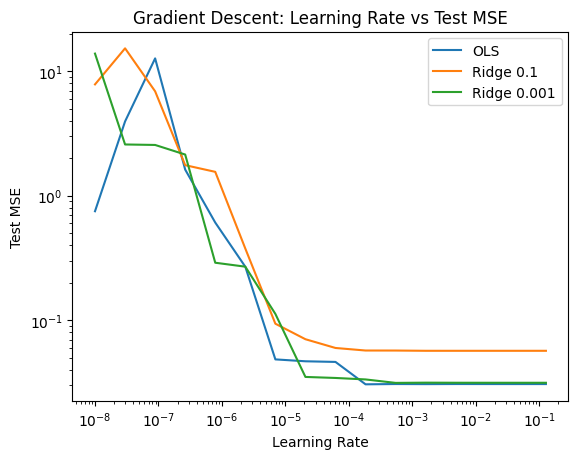

In [18]:
plt.plot(df_ols['Parameters'], df_ols['Result Objective'], label='OLS')
plt.plot(df_ridge_1['Parameters'], df_ridge_1['Result Objective'], label='Ridge 0.1')
plt.plot(df_ridge_3['Parameters'], df_ridge_3['Result Objective'], label='Ridge 0.001')

# plt.axhline(y=mse_exact_OLS, color='blue', linestyle='--', label='Exact OLS')
# plt.axhline(y=mse_exact_Ridge_1, color='orange', linestyle='--', label='Exact Ridge 0.1')
# plt.axhline(y=mse_exact_Ridge_3, color='green', linestyle='--', label='Exact Ridge 0.001')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test MSE')
plt.title('Gradient Descent: Learning Rate vs Test MSE')
plt.legend()
plt.show()

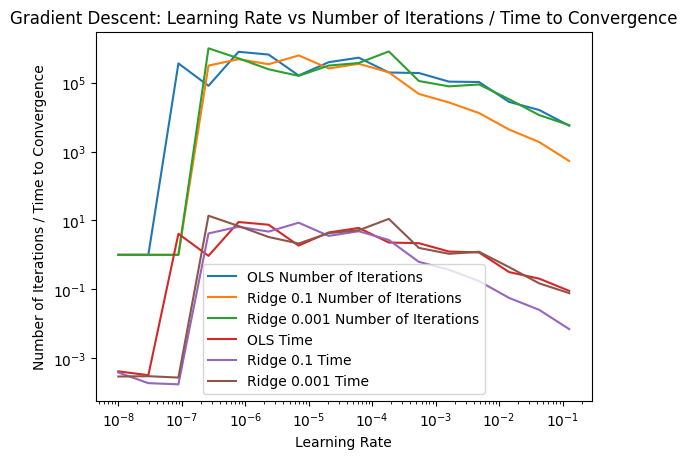

In [19]:
plt.plot(df_ols['Parameters'], df_ols['Number of Iterations'], label='OLS Number of Iterations')
plt.plot(df_ridge_1['Parameters'], df_ridge_1['Number of Iterations'], label='Ridge 0.1 Number of Iterations')
plt.plot(df_ridge_3['Parameters'], df_ridge_3['Number of Iterations'], label='Ridge 0.001 Number of Iterations')

plt.plot(df_ols['Parameters'], df_ols['Time'], label='OLS Time')
plt.plot(df_ridge_1['Parameters'], df_ridge_1['Time'], label='Ridge 0.1 Time')
plt.plot(df_ridge_3['Parameters'], df_ridge_3['Time'], label='Ridge 0.001 Time')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Iterations / Time to Convergence')
plt.title('Gradient Descent: Learning Rate vs Number of Iterations / Time to Convergence')
plt.legend()
plt.show()

**Andere Updateverfahren ohne Stochastik**

In [77]:
parameters = np.logspace(-8, 1, num=10)

In [ ]:
function_OLS_normal = lambda param: gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_normal = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_normal = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)

function_OLS_momentum = lambda param: gradient_descent_momentum(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_momentum = lambda param: gradient_descent_momentum(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_momentum = lambda param: gradient_descent_momentum(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)

function_OLS_ADAgrad = lambda param: gradient_descent_adagrad(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_ADAgrad = lambda param: gradient_descent_adagrad(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_ADAgrad = lambda param: gradient_descent_adagrad(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)

function_OLS_RMSprop = lambda param: gradient_descent_rmsprop(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_RMSprop = lambda param: gradient_descent_rmsprop(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_RMSprop = lambda param: gradient_descent_rmsprop(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)

function_OLS_Adam = lambda param: gradient_descent_adam(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_Adam = lambda param: gradient_descent_adam(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_Adam = lambda param: gradient_descent_adam(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)



results_OLS_normal = tuning(function_OLS_normal, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_normal = tuning(function_Ridge_normal, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_normal = tuning(function_Lasso_normal, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_momentum = tuning(function_OLS_momentum, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_momentum = tuning(function_Ridge_momentum, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_momentum = tuning(function_Lasso_momentum, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_ADAgrad = tuning(function_OLS_ADAgrad, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_ADAgrad = tuning(function_Ridge_ADAgrad, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_ADAgrad = tuning(function_Lasso_ADAgrad, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_RMSprop = tuning(function_OLS_RMSprop, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_RMSprop = tuning(function_Ridge_RMSprop, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_RMSprop = tuning(function_Lasso_RMSprop, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_Adam = tuning(function_OLS_Adam, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_Adam = tuning(function_Ridge_Adam, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_Adam = tuning(function_Lasso_Adam, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

In [21]:
df_OLS_normal = results_OLS_normal[0]
df_OLS_normal = df_OLS_normal[np.isfinite(df_OLS_normal['Result Objective'])].reset_index(drop=True)
df_Ridge_normal = results_Ridge_normal[0]
df_Ridge_normal = df_Ridge_normal[np.isfinite(df_Ridge_normal['Result Objective'])].reset_index(drop=True)
df_Lasso_normal = results_Lasso_normal[0]
df_Lasso_normal = df_Lasso_normal[np.isfinite(df_Lasso_normal['Result Objective'])].reset_index(drop=True)

df_OLS_momentum = results_OLS_momentum[0]
df_OLS_momentum = df_OLS_momentum[np.isfinite(df_OLS_momentum['Result Objective'])].reset_index(drop=True)
df_Ridge_momentum = results_Ridge_momentum[0]
df_Ridge_momentum = df_Ridge_momentum[np.isfinite(df_Ridge_momentum['Result Objective'])].reset_index(drop=True)
df_Lasso_momentum = results_Lasso_momentum[0]
df_Lasso_momentum = df_Lasso_momentum[np.isfinite(df_Lasso_momentum['Result Objective'])].reset_index(drop=True)

df_OLS_ADAgrad = results_OLS_ADAgrad[0]
df_OLS_ADAgrad = df_OLS_ADAgrad[np.isfinite(df_OLS_ADAgrad['Result Objective'])].reset_index(drop=True)
df_Ridge_ADAgrad = results_Ridge_ADAgrad[0]
df_Ridge_ADAgrad = df_Ridge_ADAgrad[np.isfinite(df_Ridge_ADAgrad['Result Objective'])].reset_index(drop=True)
df_Lasso_ADAgrad = results_Lasso_ADAgrad[0]
df_Lasso_ADAgrad = df_Lasso_ADAgrad[np.isfinite(df_Lasso_ADAgrad['Result Objective'])].reset_index(drop=True)

df_OLS_RMSprop = results_OLS_RMSprop[0]
df_OLS_RMSprop = df_OLS_RMSprop[np.isfinite(df_OLS_RMSprop['Result Objective'])].reset_index(drop=True)
df_Ridge_RMSprop = results_Ridge_RMSprop[0]
df_Ridge_RMSprop = df_Ridge_RMSprop[np.isfinite(df_Ridge_RMSprop['Result Objective'])].reset_index(drop=True)
df_Lasso_RMSprop = results_Lasso_RMSprop[0]
df_Lasso_RMSprop = df_Lasso_RMSprop[np.isfinite(df_Lasso_RMSprop['Result Objective'])].reset_index(drop=True)

df_OLS_Adam = results_OLS_Adam[0]
df_OLS_Adam = df_OLS_Adam[np.isfinite(df_OLS_Adam['Result Objective'])].reset_index(drop=True)
df_Ridge_Adam = results_Ridge_Adam[0]
df_Ridge_Adam = df_Ridge_Adam[np.isfinite(df_Ridge_Adam['Result Objective'])].reset_index(drop=True)
df_Lasso_Adam = results_Lasso_Adam[0]
df_Lasso_Adam = df_Lasso_Adam[np.isfinite(df_Lasso_Adam['Result Objective'])].reset_index(drop=True)

**Andere Updateverfahren mit Stochastik**

In [ ]:
function_OLS_normal_stochastic = lambda param: gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_normal_stochastic = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_normal_stochastic = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)

function_OLS_momentum_stochastic = lambda param: gradient_descent_momentum(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_momentum_stochastic = lambda param: gradient_descent_momentum(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_momentum_stochastic = lambda param: gradient_descent_momentum(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)

function_OLS_ADAgrad_stochastic = lambda param: gradient_descent_adagrad(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_ADAgrad_stochastic = lambda param: gradient_descent_adagrad(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_ADAgrad_stochastic = lambda param: gradient_descent_adagrad(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)

function_OLS_RMSprop_stochastic = lambda param: gradient_descent_rmsprop(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_RMSprop_stochastic = lambda param: gradient_descent_rmsprop(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_RMSprop_stochastic = lambda param: gradient_descent_rmsprop(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)

function_OLS_Adam_stochastic = lambda param: gradient_descent_adam(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_Adam_stochastic = lambda param: gradient_descent_adam(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_Adam_stochastic = lambda param: gradient_descent_adam(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)




results_OLS_normal_stochastic = tuning(function_OLS_normal_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_normal_stochastic = tuning(function_Ridge_normal_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_normal_stochastic = tuning(function_Lasso_normal_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_momentum_stochastic = tuning(function_OLS_momentum_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_momentum_stochastic = tuning(function_Ridge_momentum_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_momentum_stochastic = tuning(function_Lasso_momentum_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_ADAgrad_stochastic = tuning(function_OLS_ADAgrad_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_ADAgrad_stochastic = tuning(function_Ridge_ADAgrad_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_ADAgrad_stochastic = tuning(function_Lasso_ADAgrad_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_RMSprop_stochastic = tuning(function_OLS_RMSprop_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_RMSprop_stochastic = tuning(function_Ridge_RMSprop_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_RMSprop_stochastic = tuning(function_Lasso_RMSprop_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_Adam_stochastic = tuning(function_OLS_Adam_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_Adam_stochastic = tuning(function_Ridge_Adam_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_Adam_stochastic = tuning(function_Lasso_Adam_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

In [23]:
df_OLS_normal_stochastic = results_OLS_normal_stochastic[0]
df_OLS_normal_stochastic = df_OLS_normal_stochastic[np.isfinite(df_OLS_normal_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_normal_stochastic = results_Ridge_normal_stochastic[0]
df_Ridge_normal_stochastic = df_Ridge_normal_stochastic[np.isfinite(df_Ridge_normal_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_normal_stochastic = results_Lasso_normal_stochastic[0]
df_Lasso_normal_stochastic = df_Lasso_normal_stochastic[np.isfinite(df_Lasso_normal_stochastic['Result Objective'])].reset_index(drop=True)

df_OLS_momentum_stochastic = results_OLS_momentum_stochastic[0]
df_OLS_momentum_stochastic = df_OLS_momentum_stochastic[np.isfinite(df_OLS_momentum_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_momentum_stochastic = results_Ridge_momentum_stochastic[0]
df_Ridge_momentum_stochastic = df_Ridge_momentum_stochastic[np.isfinite(df_Ridge_momentum_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_momentum_stochastic = results_Lasso_momentum_stochastic[0]
df_Lasso_momentum_stochastic = df_Lasso_momentum_stochastic[np.isfinite(df_Lasso_momentum_stochastic['Result Objective'])].reset_index(drop=True)

df_OLS_ADAgrad_stochastic = results_OLS_ADAgrad_stochastic[0]
df_OLS_ADAgrad_stochastic = df_OLS_ADAgrad_stochastic[np.isfinite(df_OLS_ADAgrad_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_ADAgrad_stochastic = results_Ridge_ADAgrad_stochastic[0]
df_Ridge_ADAgrad_stochastic = df_Ridge_ADAgrad_stochastic[np.isfinite(df_Ridge_ADAgrad_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_ADAgrad_stochastic = results_Lasso_ADAgrad_stochastic[0]
df_Lasso_ADAgrad_stochastic = df_Lasso_ADAgrad_stochastic[np.isfinite(df_Lasso_ADAgrad_stochastic['Result Objective'])].reset_index(drop=True)

df_OLS_RMSprop_stochastic = results_OLS_RMSprop_stochastic[0]
df_OLS_RMSprop_stochastic = df_OLS_RMSprop_stochastic[np.isfinite(df_OLS_RMSprop_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_RMSprop_stochastic = results_Ridge_RMSprop_stochastic[0]
df_Ridge_RMSprop_stochastic = df_Ridge_RMSprop_stochastic[np.isfinite(df_Ridge_RMSprop_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_RMSprop_stochastic = results_Lasso_RMSprop_stochastic[0]
df_Lasso_RMSprop_stochastic = df_Lasso_RMSprop_stochastic[np.isfinite(df_Lasso_RMSprop_stochastic['Result Objective'])].reset_index(drop=True)

df_OLS_Adam_stochastic = results_OLS_Adam_stochastic[0]
df_OLS_Adam_stochastic = df_OLS_Adam_stochastic[np.isfinite(df_OLS_Adam_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_Adam_stochastic = results_Ridge_Adam_stochastic[0]
df_Ridge_Adam_stochastic = df_Ridge_Adam_stochastic[np.isfinite(df_Ridge_Adam_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_Adam_stochastic = results_Lasso_Adam_stochastic[0]
df_Lasso_Adam_stochastic = df_Lasso_Adam_stochastic[np.isfinite(df_Lasso_Adam_stochastic['Result Objective'])].reset_index(drop=True)

**Results**

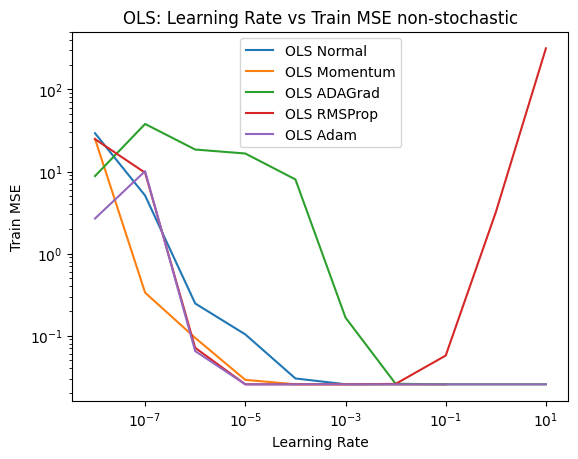

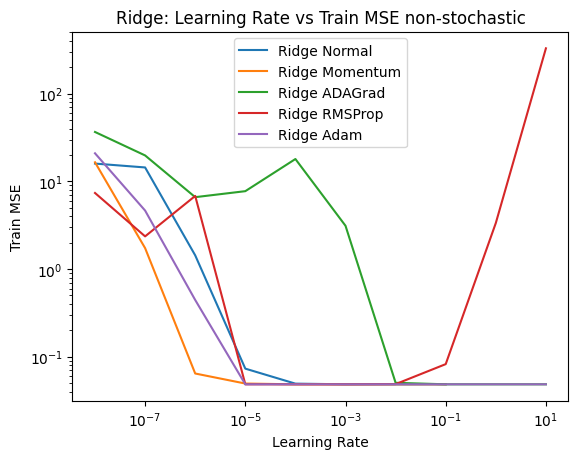

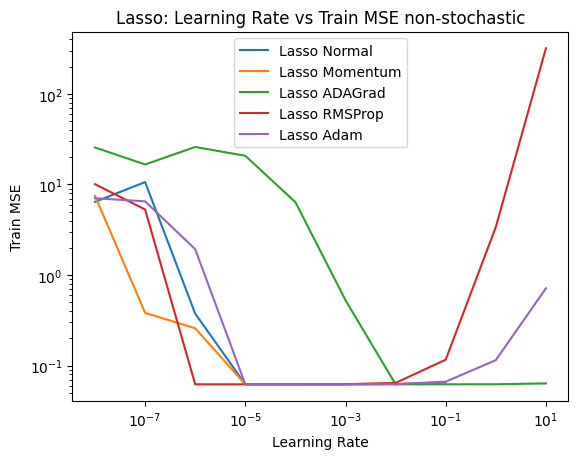

In [24]:
plt.plot(df_OLS_normal['Parameters'], df_OLS_normal['Result Objective'], label='OLS Normal')
plt.plot(df_OLS_momentum['Parameters'], df_OLS_momentum['Result Objective'], label='OLS Momentum')
plt.plot(df_OLS_ADAgrad['Parameters'], df_OLS_ADAgrad['Result Objective'], label='OLS ADAGrad')
plt.plot(df_OLS_RMSprop['Parameters'], df_OLS_RMSprop['Result Objective'], label='OLS RMSProp')
plt.plot(df_OLS_Adam['Parameters'], df_OLS_Adam['Result Objective'], label='OLS Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('OLS: Learning Rate vs Train MSE non-stochastic')
plt.legend()
plt.show()


plt.plot(df_Ridge_normal['Parameters'], df_Ridge_normal['Result Objective'], label='Ridge Normal')
plt.plot(df_Ridge_momentum['Parameters'], df_Ridge_momentum['Result Objective'], label='Ridge Momentum')
plt.plot(df_Ridge_ADAgrad['Parameters'], df_Ridge_ADAgrad['Result Objective'], label='Ridge ADAGrad')
plt.plot(df_Ridge_RMSprop['Parameters'], df_Ridge_RMSprop['Result Objective'], label='Ridge RMSProp')
plt.plot(df_Ridge_Adam['Parameters'], df_Ridge_Adam['Result Objective'], label='Ridge Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('Ridge: Learning Rate vs Train MSE non-stochastic')
plt.legend()
plt.show()


plt.plot(df_Lasso_normal['Parameters'], df_Lasso_normal['Result Objective'], label='Lasso Normal')
plt.plot(df_Lasso_momentum['Parameters'], df_Lasso_momentum['Result Objective'], label='Lasso Momentum')
plt.plot(df_Lasso_ADAgrad['Parameters'], df_Lasso_ADAgrad['Result Objective'], label='Lasso ADAGrad')
plt.plot(df_Lasso_RMSprop['Parameters'], df_Lasso_RMSprop['Result Objective'], label='Lasso RMSProp')
plt.plot(df_Lasso_Adam['Parameters'], df_Lasso_Adam['Result Objective'], label='Lasso Adam')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('Lasso: Learning Rate vs Train MSE non-stochastic')
plt.legend()
plt.show()

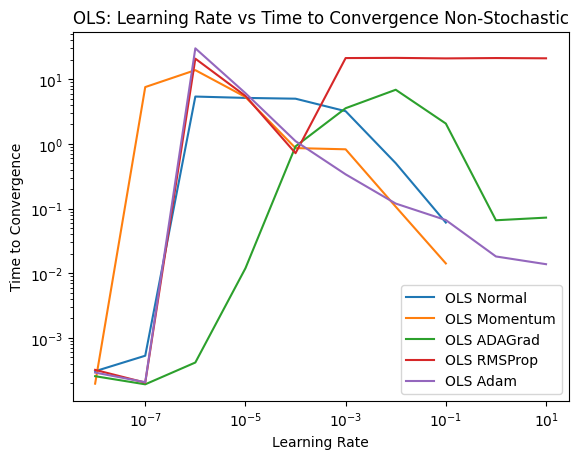

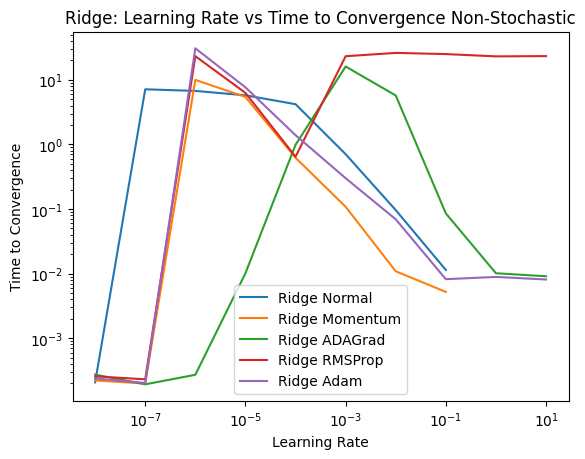

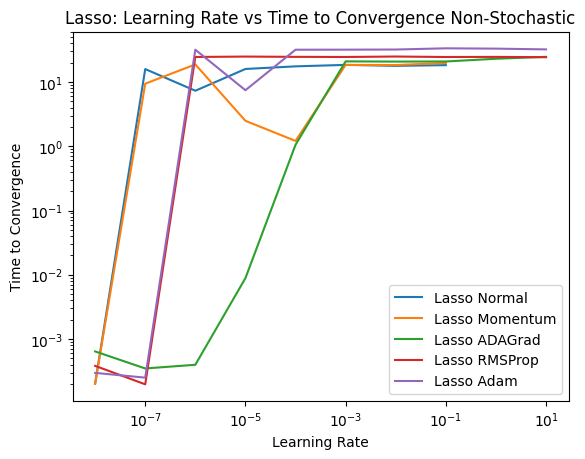

In [25]:
plt.plot(df_OLS_normal['Parameters'], df_OLS_normal['Time'], label='OLS Normal')
plt.plot(df_OLS_momentum['Parameters'], df_OLS_momentum['Time'], label='OLS Momentum')
plt.plot(df_OLS_ADAgrad['Parameters'], df_OLS_ADAgrad['Time'], label='OLS ADAGrad')
plt.plot(df_OLS_RMSprop['Parameters'], df_OLS_RMSprop['Time'], label='OLS RMSProp')
plt.plot(df_OLS_Adam['Parameters'], df_OLS_Adam['Time'], label='OLS Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('OLS: Learning Rate vs Time to Convergence Non-Stochastic')
plt.legend()
plt.show()


plt.plot(df_Ridge_normal['Parameters'], df_Ridge_normal['Time'], label='Ridge Normal')
plt.plot(df_Ridge_momentum['Parameters'], df_Ridge_momentum['Time'], label='Ridge Momentum')
plt.plot(df_Ridge_ADAgrad['Parameters'], df_Ridge_ADAgrad['Time'], label='Ridge ADAGrad')
plt.plot(df_Ridge_RMSprop['Parameters'], df_Ridge_RMSprop['Time'], label='Ridge RMSProp')
plt.plot(df_Ridge_Adam['Parameters'], df_Ridge_Adam['Time'], label='Ridge Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('Ridge: Learning Rate vs Time to Convergence Non-Stochastic')
plt.legend()
plt.show()


plt.plot(df_Lasso_normal['Parameters'], df_Lasso_normal['Time'], label='Lasso Normal')
plt.plot(df_Lasso_momentum['Parameters'], df_Lasso_momentum['Time'], label='Lasso Momentum')
plt.plot(df_Lasso_ADAgrad['Parameters'], df_Lasso_ADAgrad['Time'], label='Lasso ADAGrad')
plt.plot(df_Lasso_RMSprop['Parameters'], df_Lasso_RMSprop['Time'], label='Lasso RMSProp')
plt.plot(df_Lasso_Adam['Parameters'], df_Lasso_Adam['Time'], label='Lasso Adam')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('Lasso: Learning Rate vs Time to Convergence Non-Stochastic')
plt.legend()
plt.show()

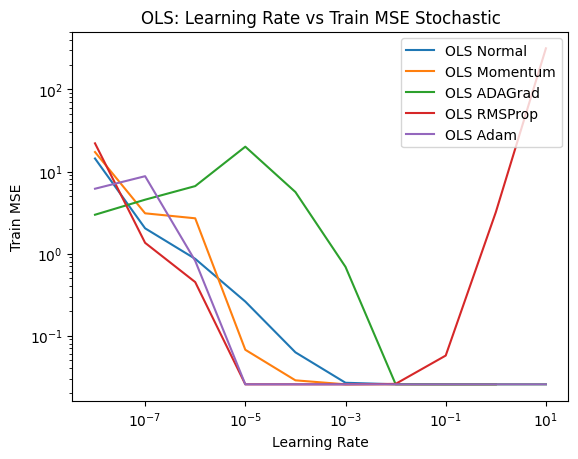

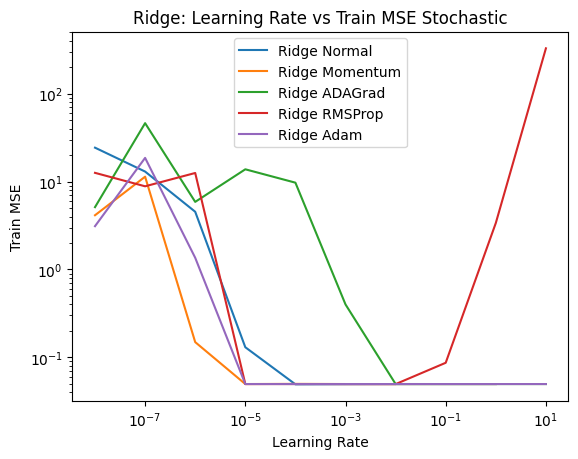

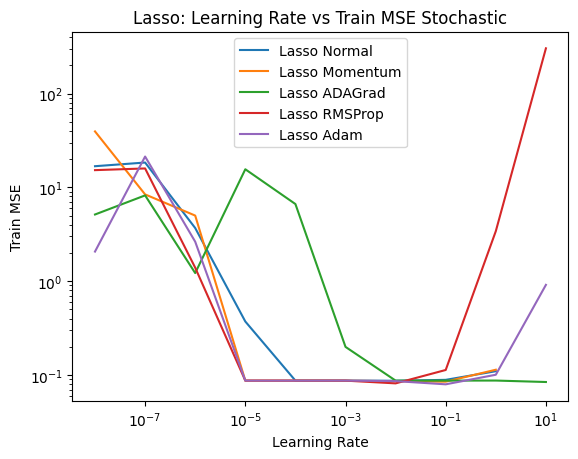

In [26]:
plt.plot(df_OLS_normal_stochastic['Parameters'], df_OLS_normal_stochastic['Result Objective'], label='OLS Normal')
plt.plot(df_OLS_momentum_stochastic['Parameters'], df_OLS_momentum_stochastic['Result Objective'], label='OLS Momentum')
plt.plot(df_OLS_ADAgrad_stochastic['Parameters'], df_OLS_ADAgrad_stochastic['Result Objective'], label='OLS ADAGrad')
plt.plot(df_OLS_RMSprop_stochastic['Parameters'], df_OLS_RMSprop_stochastic['Result Objective'], label='OLS RMSProp')
plt.plot(df_OLS_Adam_stochastic['Parameters'], df_OLS_Adam_stochastic['Result Objective'], label='OLS Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('OLS: Learning Rate vs Train MSE Stochastic')
plt.legend()
plt.show()


plt.plot(df_Ridge_normal_stochastic['Parameters'], df_Ridge_normal_stochastic['Result Objective'], label='Ridge Normal')
plt.plot(df_Ridge_momentum_stochastic['Parameters'], df_Ridge_momentum_stochastic['Result Objective'], label='Ridge Momentum')
plt.plot(df_Ridge_ADAgrad_stochastic['Parameters'], df_Ridge_ADAgrad_stochastic['Result Objective'], label='Ridge ADAGrad')
plt.plot(df_Ridge_RMSprop_stochastic['Parameters'], df_Ridge_RMSprop_stochastic['Result Objective'], label='Ridge RMSProp')
plt.plot(df_Ridge_Adam_stochastic['Parameters'], df_Ridge_Adam_stochastic['Result Objective'], label='Ridge Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('Ridge: Learning Rate vs Train MSE Stochastic')
plt.legend()
plt.show()


plt.plot(df_Lasso_normal_stochastic['Parameters'], df_Lasso_normal_stochastic['Result Objective'], label='Lasso Normal')
plt.plot(df_Lasso_momentum_stochastic['Parameters'], df_Lasso_momentum_stochastic['Result Objective'], label='Lasso Momentum')
plt.plot(df_Lasso_ADAgrad_stochastic['Parameters'], df_Lasso_ADAgrad_stochastic['Result Objective'], label='Lasso ADAGrad')
plt.plot(df_Lasso_RMSprop_stochastic['Parameters'], df_Lasso_RMSprop_stochastic['Result Objective'], label='Lasso RMSProp')
plt.plot(df_Lasso_Adam_stochastic['Parameters'], df_Lasso_Adam_stochastic['Result Objective'], label='Lasso Adam')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('Lasso: Learning Rate vs Train MSE Stochastic')
plt.legend()
plt.show()

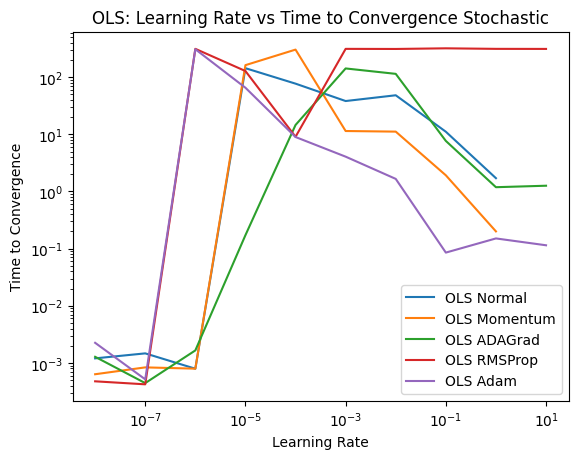

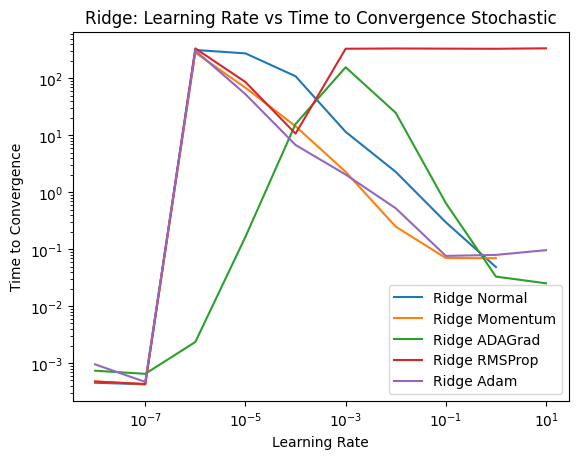

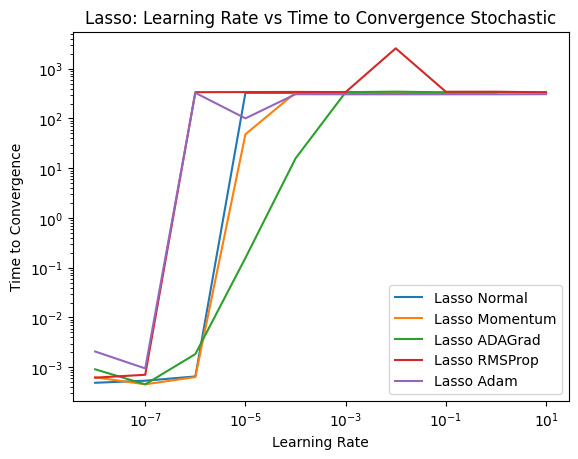

In [51]:
plt.plot(df_OLS_normal_stochastic['Parameters'], df_OLS_normal_stochastic['Time'], label='OLS Normal')
plt.plot(df_OLS_momentum_stochastic['Parameters'], df_OLS_momentum_stochastic['Time'], label='OLS Momentum')
plt.plot(df_OLS_ADAgrad_stochastic['Parameters'], df_OLS_ADAgrad_stochastic['Time'], label='OLS ADAGrad')
plt.plot(df_OLS_RMSprop_stochastic['Parameters'], df_OLS_RMSprop_stochastic['Time'], label='OLS RMSProp')
plt.plot(df_OLS_Adam_stochastic['Parameters'], df_OLS_Adam_stochastic['Time'], label='OLS Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('OLS: Learning Rate vs Time to Convergence Stochastic')
plt.legend()
plt.show()


plt.plot(df_Ridge_normal_stochastic['Parameters'], df_Ridge_normal_stochastic['Time'], label='Ridge Normal')
plt.plot(df_Ridge_momentum_stochastic['Parameters'], df_Ridge_momentum_stochastic['Time'], label='Ridge Momentum')
plt.plot(df_Ridge_ADAgrad_stochastic['Parameters'], df_Ridge_ADAgrad_stochastic['Time'], label='Ridge ADAGrad')
plt.plot(df_Ridge_RMSprop_stochastic['Parameters'], df_Ridge_RMSprop_stochastic['Time'], label='Ridge RMSProp')
plt.plot(df_Ridge_Adam_stochastic['Parameters'], df_Ridge_Adam_stochastic['Time'], label='Ridge Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('Ridge: Learning Rate vs Time to Convergence Stochastic')
plt.legend()
plt.show()


plt.plot(df_Lasso_normal_stochastic['Parameters'], df_Lasso_normal_stochastic['Time'], label='Lasso Normal')
plt.plot(df_Lasso_momentum_stochastic['Parameters'], df_Lasso_momentum_stochastic['Time'], label='Lasso Momentum')
plt.plot(df_Lasso_ADAgrad_stochastic['Parameters'], df_Lasso_ADAgrad_stochastic['Time'], label='Lasso ADAGrad')
plt.plot(df_Lasso_RMSprop_stochastic['Parameters'], df_Lasso_RMSprop_stochastic['Time'], label='Lasso RMSProp')
plt.plot(df_Lasso_Adam_stochastic['Parameters'], df_Lasso_Adam_stochastic['Time'], label='Lasso Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('Lasso: Learning Rate vs Time to Convergence Stochastic')
plt.legend()
plt.show()

**Finding optimal learning rates via Tuning**

In [120]:
results_Lasso_Adam_stochastic[0].sort_values(by='Result Objective')

,Parameters,Result Objective,Number of Iterations,Time
7,0.10000000,0.0795610297,1000000.0,306.3800172806
6,0.01000000,0.0860660908,1000000.0,306.3861794472
4,0.00010000,0.0871336872,1000000.0,307.7656962872
3,0.00001000,0.0871393144,289868.0,100.5971357822
5,0.00100000,0.0871960223,1000000.0,306.1846976280
8,1.00000000,0.1006543884,1000000.0,306.5733792782
9,10.00000000,0.9138228829,1000000.0,307.6741383076
0,0.00000001,2.0693276554,1.0,0.0020720959
2,0.00000100,2.6357210184,1000000.0,327.8654727936
1,0.00000010,21.3227604591,1.0,0.0009472370


**Optimale Learningrate**

OLS Normal non-stochastic: 0.1, 7
Ridge Normal non-stochastic: 0.1, 7
Lasso Normal non-stochastic: 0.00001, 3

OLS Momentum non-stochastic: 0.1, 7
Ridge Momentum non-stochastic: 0.1, 7
Lasso Momentum non-stochastic: 0.0001, 4

OLS ADAgrad non-stochastic: 1.0, 8
Ridge ADAgrad non-stochastic: 1.0, 8
Lasso ADAgrad non-stochastic: 0.01, 6

OLS RMSprop non-stochastic: 0.0001, 4
Ridge RMSprop non-stochastic: 0.0001, 4
Lasso RMSprop non-stochastic: 0.000001, 2

OLS Adam non-stochastic: 1.0, 8
Ridge Adam non-stochastic: 0.1, 7
Lasso Adam non-stochastic: 0.00001, 3



OLS Normal stochastic: 1.0, 8
Ridge Normal stochastic: 1.0, 8
Lasso Normal stochastic: 0.01, 6

OLS Momentum stochastic: 1.0, 8
Ridge Momentum stochastic: 1.0, 8
Lasso Momentum stochastic: 0.1, 7

OLS ADAgrad stochastic: 1.0, 8
Ridge ADAgrad stochastic: 10.0, 9
Lasso ADAgrad stochastic: 10.0, 9

OLS RMSprop stochastic: 0.0001, 4
Ridge RMSprop stochastic: 0.0001, 4
Lasso RMSprop stochastic: 0.01, 6

OLS Adam stochastic: 0.1, 7
Ridge Adam stochastic: 1.0, 8
Lasso Adam stochastic: 0.1, 7

In [135]:
results_OLS = [results_OLS_normal, results_OLS_momentum, results_OLS_ADAgrad, results_OLS_RMSprop, results_OLS_Adam, results_OLS_normal_stochastic, results_OLS_momentum_stochastic, results_OLS_ADAgrad_stochastic, results_OLS_RMSprop_stochastic, results_OLS_Adam_stochastic]
results_Ridge = [results_Ridge_normal, results_Ridge_momentum, results_Ridge_ADAgrad, results_Ridge_RMSprop, results_Ridge_Adam, results_Ridge_normal_stochastic, results_Ridge_momentum_stochastic, results_Ridge_ADAgrad_stochastic, results_Ridge_RMSprop_stochastic, results_Ridge_Adam_stochastic]
results_Lasso = [results_Lasso_normal, results_Lasso_momentum, results_Lasso_ADAgrad, results_Lasso_RMSprop, results_Lasso_Adam, results_Lasso_normal_stochastic, results_Lasso_momentum_stochastic, results_Lasso_ADAgrad_stochastic, results_Lasso_RMSprop_stochastic, results_Lasso_Adam_stochastic]
table = lambda: [
    ["normal non-stoch", 7, 7, 3],
    ["momentum non-stoch", 7, 7, 4],
    ["ADAGrad non-stoch", 8, 8, 6],
    ["RMSProp non-stoch", 4, 4, 2],
    ["Adam non-stoch", 8, 7, 3],

    ["normal stoch", 8, 8, 6],
    ["momentum stoch", 8, 8, 7],
    ["ADAGrad stoch", 8, 9, 9],
    ["RMSProp stoch", 4, 4, 6],
    ["Adam stoch", 7, 8, 7],
]

print("OLS:")
print("\hline OLS & Train & Test & Time \\\ \hline")
for idx, line in enumerate(table()):
    line.append(maker_objective_ols(X_train, y_train)(results_OLS[idx][1][parameters[line[1]]]))
    line.append(maker_objective_ols(X_test, y_test)(results_OLS[idx][1][parameters[line[1]]]))
    line.append(results_OLS[idx][0]['Time'][line[1]])

    print("".join([line[0]] + [f" & {line[i+4]:.4e}" for i in range(3)] + [" \\\ \hline"]))

print("\nRidge:")
print("\hline Ridge & Train & Test & Time \\\ \hline")
for idx, line in enumerate(table()):
    line.append(maker_objective_ridge(X_train, y_train, lmbda=parameters[line[2]])(results_Ridge[idx][1][parameters[line[2]]]))
    line.append(maker_objective_ridge(X_test, y_test, lmbda=parameters[line[2]])(results_Ridge[idx][1][parameters[line[2]]]))
    line.append(results_Ridge[idx][0]['Time'][line[2]])

    print("".join([line[0]] + [f" & {line[i+4]:.4e}" for i in range(3)] + [" \\\ \hline"]))

print("\nLasso:")
print("\hline Lasso & Train & Test & Time \\\ \hline")
for idx, line in enumerate(table()):
    line.append(maker_objective_lasso(X_train, y_train, lmbda=parameters[line[3]])(results_Lasso[idx][1][parameters[line[3]]]))
    line.append(maker_objective_lasso(X_test, y_test, lmbda=parameters[line[3]])(results_Lasso[idx][1][parameters[line[3]]]))
    line.append(results_Lasso[idx][0]['Time'][line[3]])

    print("".join([line[0]] + [f" & {line[i+4]:.4e}" for i in range(3)] + [" \\\ \hline"]))

OLS:
\hline OLS & Train & Test & Time \\ \hline
normal non-stoch & 2.5538e-02 & 3.0706e-02 & 6.0763e-02 \\ \hline
momentum non-stoch & 2.5538e-02 & 3.0705e-02 & 1.4194e-02 \\ \hline
ADAGrad non-stoch & 2.5538e-02 & 3.0705e-02 & 6.6019e-02 \\ \hline
RMSProp non-stoch & 2.5538e-02 & 3.0705e-02 & 7.1916e-01 \\ \hline
Adam non-stoch & 2.5538e-02 & 3.0705e-02 & 1.8189e-02 \\ \hline
normal stoch & 2.5538e-02 & 3.0706e-02 & 1.7106e+00 \\ \hline
momentum stoch & 2.5538e-02 & 3.0705e-02 & 2.0044e-01 \\ \hline
ADAGrad stoch & 2.5538e-02 & 3.0705e-02 & 1.1891e+00 \\ \hline
RMSProp stoch & 2.5538e-02 & 3.0707e-02 & 9.0632e+00 \\ \hline
Adam stoch & 2.5538e-02 & 3.0705e-02 & 8.5281e-02 \\ \hline

Ridge:
\hline Ridge & Train & Test & Time \\ \hline
normal non-stoch & 4.8466e-02 & 5.6814e-02 & 1.1388e-02 \\ \hline
momentum non-stoch & 4.8466e-02 & 5.6815e-02 & 5.2087e-03 \\ \hline
ADAGrad non-stoch & 1.8137e-01 & 1.8972e-01 & 1.0131e-02 \\ \hline
RMSProp non-stoch & 3.3714e-02 & 4.2062e-02 & 6.4612e-

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:25: SyntaxWarning: invalid escape sequence '\ '
<>:28: SyntaxWarning: invalid escape sequence '\h'
<>:34: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\h'
<>:43: SyntaxWarning: invalid escape sequence '\ '
<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:25: SyntaxWarning: invalid escape sequence '\ '
<>:28: SyntaxWarning: invalid escape sequence '\h'
<>:34: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\h'
<>:43: SyntaxWarning: invalid escape sequence '\ '
C:\Users\larsb\AppData\Local\Temp\ipykernel_33088\715167353.py:19: SyntaxWarning: invalid escape sequence '\h'
  print("\hline OLS & Train & Test & Time \\\ \hline")
C:\Users\larsb\AppData\Local\Temp\ipykernel_33088\715167353.py:25: SyntaxWarning: invalid escape sequence '\ '
  print("".join([line[0]] + [f" & {line[i+4]:.4e}" for i in range(3)] + [" \\\ \hline"]))
C:\Users\larsb\AppDat

2 Bootstraps 1.3375   3 Bootstraps 14.1927   5 Bootstraps 1.2487   10 Bootstraps 37.3472   50 Bootstraps 88.0799   1000 Bootstraps 57.4549   
2 Bootstraps 1.7601   3 Bootstraps 4.5655   5 Bootstraps 18.5018   10 Bootstraps 4.7013   50 Bootstraps 226.5313   1000 Bootstraps 87.0592   
2 Bootstraps 11.9700   3 Bootstraps 21.9452   5 Bootstraps 10.3244   10 Bootstraps 11.6680   50 Bootstraps 11.2136   1000 Bootstraps 28.9789   
2 Bootstraps 1.1028   3 Bootstraps 1.1950   5 Bootstraps 1.0357   10 Bootstraps 1.1569   50 Bootstraps 1.3574   

c:\Users\larsb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+01, tolerance: 4.136e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\larsb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e+01, tolerance: 4.181e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\larsb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

1000 Bootstraps 1.3561   
2 Bootstraps 1.2346   3 Bootstraps 0.9942   5 Bootstraps 1.1979   10 Bootstraps 1.3870   50 Bootstraps 1.7464   

c:\Users\larsb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.407e+01, tolerance: 3.980e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\larsb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e+01, tolerance: 5.528e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\larsb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

1000 Bootstraps 1.5289   


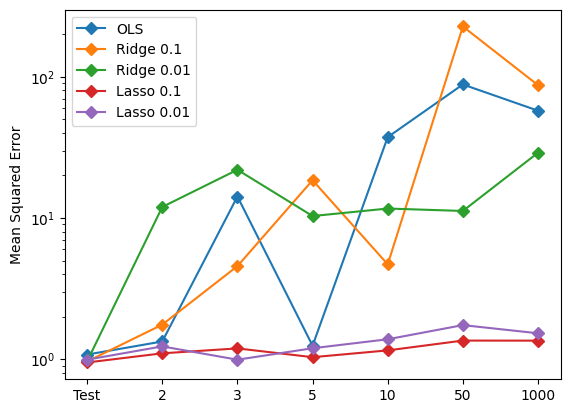

In [ ]:
n_bootstraps = [2, 3, 5, 10, N_POINTS, 1_000]

y_true = y_true.reshape(-1, 1)
def bootstrap(optimization_method, name):

    error = []

    for i, n in enumerate(n_bootstraps):
        y_pred = empty((test_data.shape[0], n))
        for j in range(n):
            x_, y_ = resample(x, y)

            X = pol.fit_transform(x_.reshape(-1, 1))

            # print(i, n, j)
            y_pred[:, j] = optimization_method.fit(X, y_).predict(pol.transform(test_data.reshape(-1, 1))).ravel()

        error.append(mean( mean((y_true - y_pred)**2, axis=1, keepdims=True) ))

        print(f"{n} Bootstraps {error[i]:.4f}", end="   ")
    
    print()
    scalar = StandardScaler()
    X = pol.fit_transform(x.reshape(-1, 1))
    X = scalar.fit_transform(X)
    y_center = y - y.mean()

    reg = optimization_method.fit(X, y_center)
    y_pred = reg.predict(scalar.transform(pol.transform(x.reshape(-1, 1)))) + y.mean()

    plt.plot(range(len(n_bootstraps)+1), [mean_squared_error(y_true, y_pred)] + error, 'D-', label=name)

for optimization_method, name in [
        (LinearRegression(), "OLS"),
        (Ridge(alpha=0.1), "Ridge 0.1"),
        (Ridge(alpha=0.01), "Ridge 0.01"),
        (Lasso(alpha=0.1), "Lasso 0.1"),
        (Lasso(alpha=0.01), "Lasso 0.01")
    ]:
    bootstrap(optimization_method, name)

plt.xticks(range(len(n_bootstraps)+1), ['Test'] + n_bootstraps)
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')
plt.show()

**OLD**

In [28]:
#find learning rate for normal gradient descent ols non stochastic
function = lambda param: gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate =param, max_iter = 1_000_000, precision = 0.000001, stochastic = False, batch_size=100)
parameters = np.logspace(-6, 1, num=30)
results_normal_ols_nonstochastic = tuning(function, parameters, maker_objective_ols(X_train, y_train))

In [29]:
print(results_normal_ols_nonstochastic[0])

       Parameters  Result Objective  Number of Iterations          Time
0    0.0000010000      0.1566172027              499282.0  5.7876114845
1    0.0000017433      0.2184569087              325295.0  3.6664500237
2    0.0000030392      0.1219683241              149710.0  1.6486856937
3    0.0000052983      0.0690631842              170227.0  1.8944900036
4    0.0000092367      0.0542231334              491114.0  5.5607321262
5    0.0000161026      0.0336233543              314558.0  3.5562603474
6    0.0000280722      0.0349279349              594009.0  7.0915796757
7    0.0000489390      0.0463595983              480125.0  5.6651279926
8    0.0000853168      0.0284133811              352061.0  3.9810597897
9    0.0001487352      0.0268021043               96595.0  1.0748496056
10   0.0002592944      0.0258060642              170521.0  1.8607554436
11   0.0004520354      0.0256584269              100531.0  1.1177384853
12   0.0007880463      0.0256224112              343189.0  3.797

In [30]:
print(results_normal_ols_nonstochastic[1][np.logspace(-6, 1, num=30)[20]])
print(results_normal_ols_nonstochastic[1][np.logspace(-6, 1, num=30)[21]])
print(results_normal_ols_nonstochastic[1][np.logspace(-6, 1, num=30)[22]])

[ 0.          0.00274236 -0.66867293 -0.00820393  0.47933264  0.00423821]
[ 0.          0.00292568 -0.6686714  -0.00872936  0.47933116  0.00460151]
[ 0.          0.00331279 -0.66866815 -0.00983886  0.47932805  0.00536867]


In [31]:
df = results_normal_ols_nonstochastic[0]
df_ols = df[np.isfinite(df['Result Objective'])].reset_index(drop=True)

In [32]:
#find learning rate for normal gradient descent ridge non stochastic
lmbda = 0.1
function = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_ridge(lmbda), learning_rate =param, max_iter = 10000, precision = 0.000001, stochastic = False, batch_size=100)
parameters = np.logspace(-6, 1, num=50)
results_normal_ridge_nonstochastic = tuning(function, parameters, maker_objective_ridge(X_train, y_train, lmbda = lmbda))
print(results_normal_ridge_nonstochastic[0])

       Parameters  Result Objective  Number of Iterations          Time
0    0.0000010000      2.5941286976               10000.0  0.1313374043
1    0.0000013895     17.3237318216               10000.0  0.1299047470
2    0.0000019307     18.3663913065               10000.0  0.1338927746
3    0.0000026827      8.4681924170               10000.0  0.1311404705
4    0.0000037276     14.1418271879               10000.0  0.1333622932
5    0.0000051795      0.4262564213               10000.0  0.1300444603
6    0.0000071969      0.8445239319               10000.0  0.1303994656
7    0.0000100000      1.8490127566               10000.0  0.1485848427
8    0.0000138950      2.6240491720               10000.0  0.1315104961
9    0.0000193070      5.3430801633               10000.0  0.1294775009
10   0.0000268270      1.0611817394               10000.0  0.1328778267
11   0.0000372759      1.4480255346               10000.0  0.1353473663
12   0.0000517947      0.3412301722               10000.0  0.130

In [33]:
values_normal_ridge_nonstochastic = results_normal_ridge_nonstochastic[1][parameters[20]]
print(values_normal_ridge_nonstochastic)

[ 0.          0.15048391 -0.14267823 -0.28971001 -0.04251018  0.14835947]


In [34]:
Ridge(alpha =0.1).fit(X_train, y_train).coef_

array([ 0.        ,  0.00309374, -0.66662659, -0.00923376,  0.47730049,
        0.00494972])

In [35]:
df = results_normal_ridge_nonstochastic[0]
df_ridge = df[np.isfinite(df['Result Objective'])].reset_index(drop=True)

In [36]:
#find learning rate for normal gradient descent lasso non stochastic
lmbda = 0.1
function = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_lasso(lmbda), learning_rate =param, max_iter = 50000, precision = 0.000001, stochastic = False, batch_size=100)
parameters = np.logspace(-6, 1, num=50)
results_normal_lasso_nonstochastic = tuning(function, parameters, maker_objective_lasso(X_train, y_train, lmbda = lmbda))
print(results_normal_lasso_nonstochastic[0])

       Parameters  Result Objective  Number of Iterations          Time
0    0.0000010000      1.9133390009               50000.0  0.6903920174
1    0.0000013895      9.2188850925               50000.0  0.6958804131
2    0.0000019307      3.3506877628               50000.0  0.7057518959
3    0.0000026827      9.8077183453               50000.0  0.6831221581
4    0.0000037276      1.4295639999               50000.0  0.6950364113
5    0.0000051795      1.1494435895               50000.0  0.7076778412
6    0.0000071969      1.1985151053               50000.0  0.6842675209
7    0.0000100000      0.4564109157               50000.0  0.6806848049
8    0.0000138950      0.7935845124               50000.0  0.7136843204
9    0.0000193070      1.3549920314               50000.0  0.7070367336
10   0.0000268270      0.2666091566               50000.0  0.6885144711
11   0.0000372759      0.1791473722               50000.0  0.7366070747
12   0.0000517947      0.4071372610               50000.0  0.886

In [37]:
values_normal_lasso_nonstochastic = results_normal_lasso_nonstochastic[1][parameters[38]]
print(values_normal_lasso_nonstochastic)

[ 0.         -0.0492201  -0.15472234 -0.08057713 -0.04217045 -0.03987078]


In [38]:
#find learning rate for adam gradient descent lasso non stochastic
lmbda = 0.1
function = lambda param: gradient_descent_adam(X_train, y_train, maker_gradient_lasso(lmbda), learning_rate =param, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7,max_iter = 50000, precision = 0.000001, stochastic = False, batch_size=100)
parameters = np.logspace(-6, 1, num=50)
results_adam_lasso_nonstochastic = tuning(function, parameters, maker_objective_lasso(X_train, y_train, lmbda = lmbda))
print(results_adam_lasso_nonstochastic[0])

       Parameters  Result Objective  Number of Iterations          Time
0    0.0000010000      8.5472218810               50000.0  1.5725483894
1    0.0000013895      4.9546936639               50000.0  1.6043071747
2    0.0000019307      4.0400631199               50000.0  1.3954319954
3    0.0000026827     10.6831399161               50000.0  1.4446561337
4    0.0000037276      3.2810809302               50000.0  1.4258580208
5    0.0000051795     47.8431874538               50000.0  1.4121775627
6    0.0000071969      4.2500228859               50000.0  1.4127721786
7    0.0000100000      2.5125036700               50000.0  1.4186799526
8    0.0000138950      1.3505400168               50000.0  1.3807318211
9    0.0000193070      1.1915610088               50000.0  1.4307019711
10   0.0000268270      0.7360714519               50000.0  1.4172923565
11   0.0000372759      0.0619814447               50000.0  1.3838040829
12   0.0000517947      0.0619835657               50000.0  1.433

In [39]:
values_normal_lasso_nonstochastic = results_normal_lasso_nonstochastic[1][0.001]
print(values_normal_lasso_nonstochastic)

[ 0.00000000e+00 -7.82889043e-05 -1.58595876e-01  7.25686456e-05
  5.53455670e-05  1.67615947e-05]


In [40]:
Lasso(alpha = 0.1).fit(X_train, y_train).coef_

array([ 0.        , -0.        , -0.10861668, -0.        , -0.        ,
       -0.        ])

In [41]:
#find learning rate for normal gradient descent ols stochastic
function = lambda param: gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate =param, max_iter = 10000, precision = 0.000001, stochastic = True, batch_size=100)
parameters =[10**i for i in range(-6, 2)]
results_normal_ols_stochastic = tuning(function, parameters, maker_objective_ols(X_train, y_train))
print(results_normal_ols_stochastic[0])

   Parameters  Result Objective  Number of Iterations          Time
0    0.000001     12.9175645034               10000.0  2.7179203033
1    0.000010     41.6619036046               10000.0  2.6365468502
2    0.000100      4.4058932423               10000.0  2.6846911907
3    0.001000      0.0712987251               10000.0  2.7359004021
4    0.010000      0.0299431364               10000.0  2.6878511906
5    0.100000      0.0259975727               10000.0  2.6532359123
6    1.000000      0.0255380631                4368.0  1.2023086548
7   10.000000               inf                   inf  0.0000000000


In [42]:
values_normal_ols_stochastic = results_normal_ols_stochastic[1][1]
print(values_normal_ols_stochastic)

[ 0.          0.00296991 -0.66867103 -0.00885612  0.47933081  0.00468916]


In [43]:
#find learning rate for momentum gradient descent ols
function = lambda param: gradient_descent_momentum(X_train, y_train, gradient_ols, learning_rate =param, momentum = 0.3, max_iter = 10000, precision = 0.000001, stochastic = False, batch_size=100)
parameters =[10**i for i in range(-6, 2)]
results_momentum_ols_nonstochastic = tuning(function, parameters, maker_objective_ols(X_train, y_train))
print(results_momentum_ols_nonstochastic[0])

   Parameters  Result Objective  Number of Iterations          Time
0    0.000001      1.3442342422               10000.0  0.1711921692
1    0.000010      1.0120676080               10000.0  0.1260142326
2    0.000100      0.4044570549               10000.0  0.1242232323
3    0.001000      0.0292322257               10000.0  0.1263492107
4    0.010000      0.0258040771               10000.0  0.1271829605
5    0.100000      0.0255380631                5957.0  0.0750689507
6    1.000000               inf                   inf  0.0000000000
7   10.000000               inf                   inf  0.0000000000


In [44]:
values_momentum_ols_nonstochastic = results_momentum_ols_nonstochastic[1][0.1]
print(values_momentum_ols_nonstochastic)

[ 0.          0.00337339 -0.66866764 -0.01001254  0.47932756  0.00548875]


In [45]:
#find learning rate for adagrad gradient descent ols
function = lambda param: gradient_descent_adagrad(X_train, y_train, gradient_ols, learning_rate =param, epsilon = 1e-7, max_iter = 10000, precision = 0.000001, stochastic = False, batch_size=100)
parameters =[10**i for i in range(-6, 2)]
results_adagrad_ols_nonstochastic = tuning(function, parameters, maker_objective_ols(X_train, y_train))
print(results_adagrad_ols_nonstochastic[0])

   Parameters  Result Objective  Number of Iterations          Time
0    0.000001     20.3046513508                   5.0  0.0006749630
1    0.000010      8.8430414543                 500.0  0.0123209953
2    0.000100      6.8467038011               10000.0  0.1483132839
3    0.001000     12.1353069183               10000.0  0.2568998337
4    0.010000      0.1434194613               10000.0  0.1701161861
5    0.100000      0.0256589928               10000.0  0.1428568363
6    1.000000      0.0255380616                2486.0  0.0386154652
7   10.000000      0.0255380618                3023.0  0.0634562969


In [46]:
values_adagrad_ols_nonstochastic = results_adagrad_ols_nonstochastic[1][10]
print(values_adagrad_ols_nonstochastic)

[ 0.          0.00331362 -0.66866817 -0.0098412   0.47932807  0.00537025]


In [47]:
#find learning rate for rmsprop gradient descent ols
function = lambda param: gradient_descent_rmsprop(X_train, y_train, gradient_ols, learning_rate =param, epsilon = 1e-7, rho= 0.9, max_iter = 10000, precision = 0.000001, stochastic = False, batch_size=100)
parameters =[10**i for i in range(-6, 2)]
results_rmsprop_ols_nonstochastic = tuning(function, parameters, maker_objective_ols(X_train, y_train))
print(results_rmsprop_ols_nonstochastic[0])

   Parameters  Result Objective  Number of Iterations          Time
0    0.000001      2.8696126066               10000.0  0.2129704952
1    0.000010     11.9085433493               10000.0  0.1788973808
2    0.000100      1.4756707907               10000.0  0.1806478500
3    0.001000      0.0255411777               10000.0  0.1914796829
4    0.010000      0.0258547899               10000.0  0.1744110584
5    0.100000      0.0572160109               10000.0  0.1840176582
6    1.000000      3.1933381167               10000.0  0.3194758892
7   10.000000    316.8055486970               10000.0  0.1870634556


In [48]:
values_rmsprop_ols_nonstochastic = results_rmsprop_ols_nonstochastic[1][0.001]
print(values_rmsprop_ols_nonstochastic)

[ 0.          0.00366854 -0.66817535 -0.00893744  0.4798231   0.00558601]


In [49]:
#find learning rate for adam gradient descent ols
function = lambda param: gradient_descent_adam(X_train, y_train, gradient_ols, learning_rate =param, epsilon = 1e-7, beta_1= 0.9, beta_2= 0.999, max_iter = 10000, precision = 0.000001, stochastic = False, batch_size=100)
parameters =[10**i for i in range(-6, 2)]
results_adam_ols_nonstochastic = tuning(function, parameters, maker_objective_ols(X_train, y_train))
print(results_adam_ols_nonstochastic[0])

   Parameters  Result Objective  Number of Iterations          Time
0    0.000001     17.1268566277               10000.0  0.3780889511
1    0.000010      1.6255962466               10000.0  0.2965388298
2    0.000100      0.2690693474               10000.0  0.3141343594
3    0.001000      0.0256890149               10000.0  0.3704919815
4    0.010000      0.0255380608                5943.0  0.1698827744
5    0.100000      0.0255380606                1508.0  0.0401096344
6    1.000000      0.0255380606                 394.0  0.0096654892
7   10.000000      0.0255380606                 337.0  0.0092735291


In [50]:
values_adam_ols_nonstochastic = results_adam_ols_nonstochastic[1][10]
print(values_adam_ols_nonstochastic)

[ 0.          0.00319153 -0.66866943 -0.00949188  0.47932879  0.00512858]
